<a href="https://colab.research.google.com/github/piziomo/Data-Science/blob/main/Clustering/Glustering%20and%20Ground%20Truth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#| echo: false

# We are suppressing warnings for now. Comment lines below if you want to see the warnings, as they tend to be informative.
import warnings
warnings.filterwarnings('ignore')

# Lab: Clustering and Ground Truth


We are going to use the Wine Quality Dataset from @cortezWineQuality2009 that you may be familiar with by now (but if you don't, tou can find more information about it here: <https://doi.org/10.24432/C56S3T>).

## Data Wrangling


In [ ]:
import pandas as pd

df = pd.read_csv('data/wine.csv')

Look at our data.

In [ ]:
df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


There is a column called Class label that gives us the ground truth. The wines come from three different cultivars. Knowing the actual grouping helps us to identify how well our methods can capture this ground truth.

Following our process above, we should first get a sense of our data.

In [ ]:
df.describe()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


No missing data. The scales of our features vary (e.g., Magnesium is in the 100s whereas Hue is in the low single digits).

How about our feature distributions?

[Text(0, 0, 'Alcohol'),
 Text(1, 0, 'Malic acid'),
 Text(2, 0, 'Ash'),
 Text(3, 0, 'Alcalinity of ash'),
 Text(4, 0, 'Magnesium'),
 Text(5, 0, 'Total phenols'),
 Text(6, 0, 'Flavanoids'),
 Text(7, 0, 'Nonflavanoid phenols'),
 Text(8, 0, 'Proanthocyanins'),
 Text(9, 0, 'Color intensity'),
 Text(10, 0, 'Hue'),
 Text(11, 0, 'OD280/OD315 of diluted wines'),
 Text(12, 0, 'Proline ')]

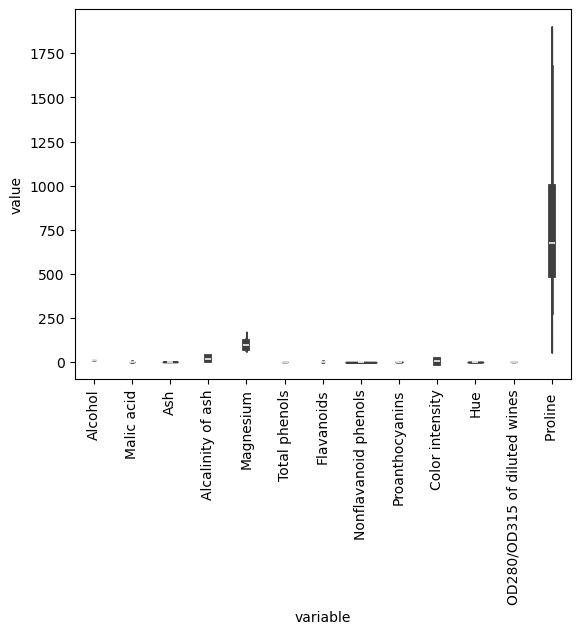

In [ ]:
# Reshape from wide to long format, so we can easily view all variables in a single plot.
df_long = df.melt(id_vars='Class label')

import seaborn as sns

# Create seaborn violin plot
my_plot = sns.violinplot(data = df_long, x = 'variable', y = 'value')

# Rotate x-axis labels
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)

As you can see, the scale of the different variables diffes enormously (this is specially true with `Proline` -refer to the output after `df.describe()`), so it makes sense to normalise our data.

### Normalise data

::: callout-warning

Please note that `Class label` is a numerical column that in fact describes the ground truth categories, so it doesn't make sense to normalise that variable. Therefore, **we should exclude `Class label` from the normalisation.**

:::

In [ ]:
# Store labels as a variable before removing them from the dataframe
class_labels = df["Class label"]

df_subset = df.iloc[:,1:]

from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df_subset), columns = df_subset.columns)

# Re-add class labels in the first position
df_norm.insert(0, "Class label", class_labels)

df_norm


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,1,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,1,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,1,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,0.705263,0.970356,0.582888,0.510309,0.271739,0.241379,0.056962,0.735849,0.205047,0.547782,0.130081,0.172161,0.329529
174,3,0.623684,0.626482,0.598930,0.639175,0.347826,0.282759,0.086498,0.566038,0.315457,0.513652,0.178862,0.106227,0.336662
175,3,0.589474,0.699605,0.481283,0.484536,0.543478,0.210345,0.073840,0.566038,0.296530,0.761092,0.089431,0.106227,0.397290
176,3,0.563158,0.365613,0.540107,0.484536,0.543478,0.231034,0.071730,0.754717,0.331230,0.684300,0.097561,0.128205,0.400856


[Text(0, 0, 'Alcohol'),
 Text(1, 0, 'Malic acid'),
 Text(2, 0, 'Ash'),
 Text(3, 0, 'Alcalinity of ash'),
 Text(4, 0, 'Magnesium'),
 Text(5, 0, 'Total phenols'),
 Text(6, 0, 'Flavanoids'),
 Text(7, 0, 'Nonflavanoid phenols'),
 Text(8, 0, 'Proanthocyanins'),
 Text(9, 0, 'Color intensity'),
 Text(10, 0, 'Hue'),
 Text(11, 0, 'OD280/OD315 of diluted wines'),
 Text(12, 0, 'Proline ')]

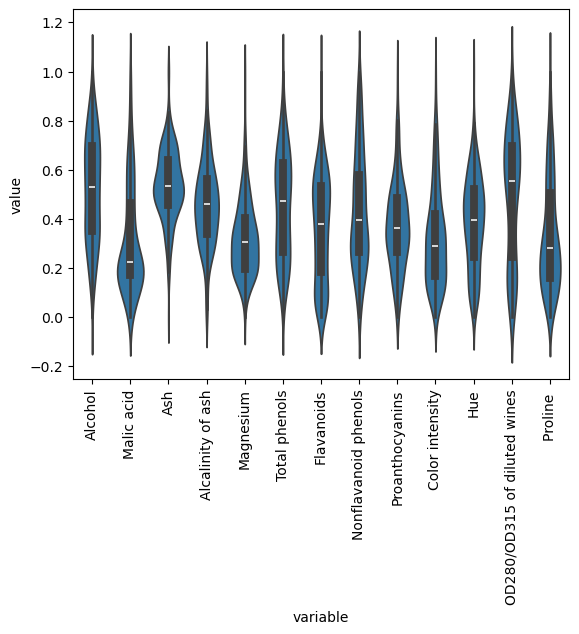

In [ ]:
# Reshape from wide to long format
df_long = df_norm.melt(id_vars='Class label')

# Create seaborn violin plot
my_plot = sns.violinplot(data = df_long, x = 'variable', y = 'value')

# Rotate x-axis labels
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)



Are there any patterns?

How about a pairplot?

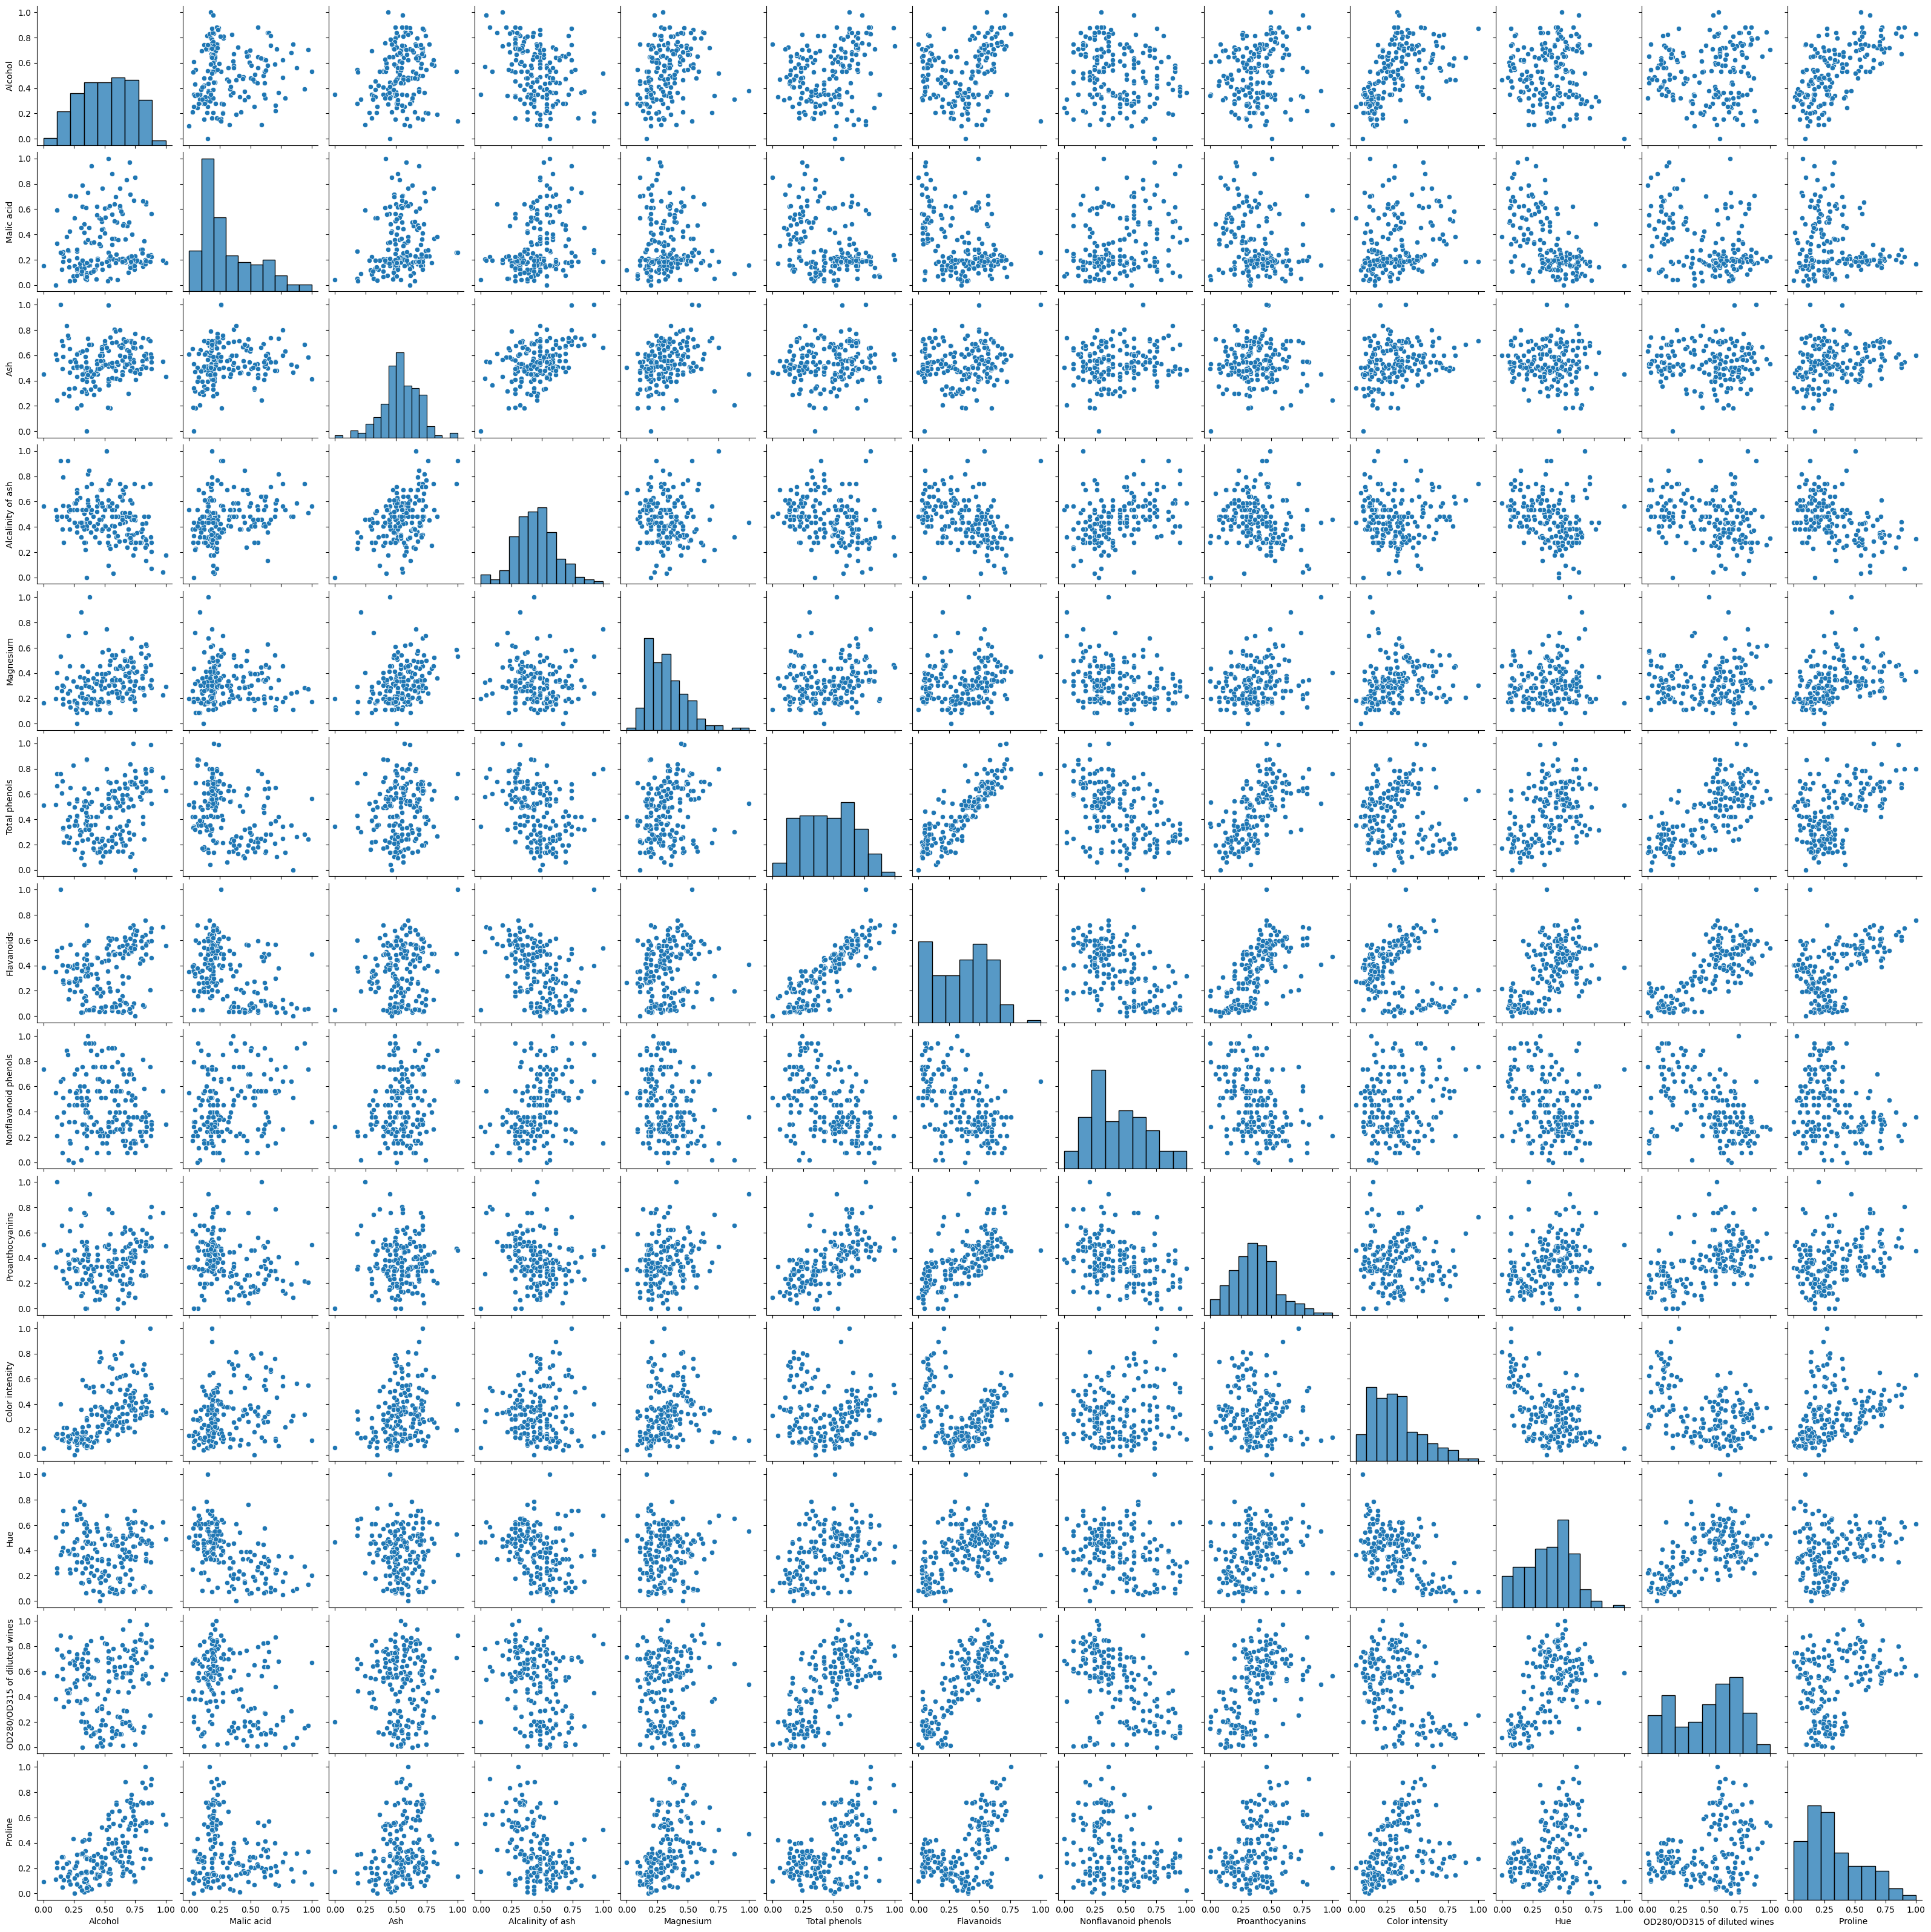

In [ ]:
#| column: page
sns.pairplot(data = df_norm.iloc[:,1:])

Hmm, a few interesting correlations. Some of our variables are skewed. We could apply some PCA here to look at fewer dimension or even log transform some of the skewed variables.

## Cluster analysis

For now we will just run a kmeans cluster and then check our results against the ground truth.

### Determining the number of clusters

Lets decide how many clusters we need.

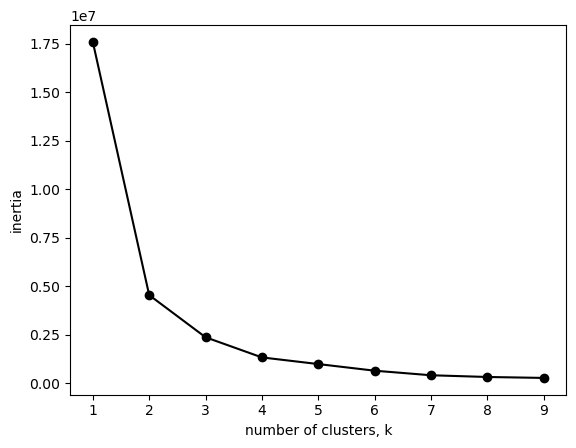

In [ ]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init = 10)

    # Fit model to samples
    model.fit(df.iloc[:,1:])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

What happens if we use the normalised data instead?

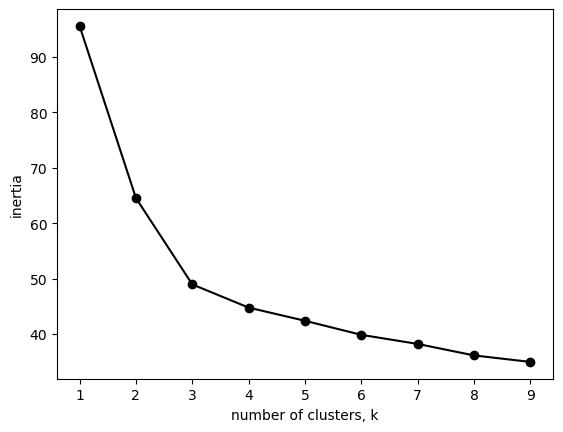

In [ ]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init = 10)

    # Fit model to samples
    model.fit(df_norm.iloc[:,1:])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

:::callout-warning
### Pause for thought

Both of the graphs are the same. Is that what you would expect?

:::

Three clusters seems about right (and matches our number of origonal labels).

In [ ]:
df['Class label'].value_counts()

Class label
2    71
1    59
3    48
Name: count, dtype: int64

### Computing the clusters

In [ ]:
# Create a KMeans instance with k clusters: model
k_means = KMeans(n_clusters=3)

# Fit model to samples
df_k_means = k_means.fit(df.iloc[:,1:])

df['Three clusters'] = pd.Series(df_k_means.predict(df.iloc[:,1:].values), index = df.index)
df

In [ ]:
# Create a KMeans instance with k clusters: model
k_means = KMeans(n_clusters=3)

# Fit model to samples using normalised dataframe
df_k_means = k_means.fit(df_norm.iloc[:,1:])

df_norm['Three clusters'] = pd.Series(df_k_means.predict(df_norm.iloc[:,1:].values), index = df_norm.index)
df_norm

## Clusters and Ground Truth
Now that we have created three clusters, we may ask ourselves: Do our cluster labels match our ground truth? Did our cluster model capture reality?

In [ ]:
ct = pd.crosstab(df['Three clusters'], df['Class label'])
ct

And now, we will repeat the same with the normalised dataframe:

In [ ]:
ct_norm = pd.crosstab(df_norm['Three clusters'], df_norm['Class label'])
ct_norm

It might be easier to see as a stacked plot (see [this post](https://stackoverflow.com/questions/43544694/using-pandas-crosstab-with-seaborn-stacked-barplots)).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ct.plot.bar(stacked=True)
plt.legend(title='Class label')
plt.title(label = 'Clusters and ground truth (original dataset)')

And now, we repeat the same, but using the normalised dataset:

In [ ]:
# use the normalised dataset
ct_norm.plot.bar(stacked=True)
plt.legend(title='Class label')
plt.title(label = 'Clusters and ground truth (normalised dataset)')

::: callout-caution

## How has the kmeans model done compared to our ground truth?

1. Check the difference between the clusters using the original dataframe and the normalised dataframe.
2. Reflect on the meaning of the labels: Are the labels from ground truth and cluster labels related somehow? Are the labels meaningful?

:::

::: callout-important

We need to be really careful here. We notice that it is not easily possible to compare the known class labels to clustering labels. The reason is that the clustering algorithm labels are just arbitrary and not assigned to any deterministic criteria. Each time you run the algorithm, you might get a different id for the labels. **The reason is that the label itself doesn't actually mean anything, what is important is the list of items that are in the same cluster and their relations.**

:::

### Principal Components Analysis

A way to come over this ambiguity and evaluate the results is to look at a visualisations of the results and compare. But this brings in the question of what type of visualisation to use for looking at the clusters. An immediate alternative is to use scatterplots. However, it is not clear which axis to use for clustering. A common method to apply at this stage is to make use of PCA to get a 2D plane where we can project the data points and visualise them over this projection.

In [ ]:
# We will be excluding the column `Class label` located in the first position from the PCA.
df.iloc[:,1:14]

And now, with the normalised dataset:

In [ ]:
# We will be excluding the column `Class label` located in the first position from the PCA.
df_norm.iloc[:,1:14]

In [ ]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)
df_pca = pca.fit(df.iloc[:,1:14])
df_pca_vals = df_pca.transform(df.iloc[:,1:14])

Again, we are repeating the same, but using the normalised dataframe:

In [ ]:
# We are repeating the same, with the normalised dataframe.

from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)
df_pca_norm = pca.fit(df_norm.iloc[:,1:14])
df_pca_norm_vals = df_pca_norm.transform(df_norm.iloc[:,1:14])

Grab our projections and plot along with our cluster names.

In [ ]:
# Store components as a new column in the original dataframe.
df['c1'] = [item[0] for item in df_pca_vals]
df['c2'] = [item[1] for item in df_pca_vals]

ax = sns.scatterplot(data = df, x = 'c1', y = 'c2', hue = 'Class label')
ax.set_title('Known labels visualised over PCs (Original data)')

And the same, with the normalised dataframe:

In [ ]:
# We are repeating the same, with the normalised dataframe.

# Store components as a new column in the normalised dataframe.
df_norm['c1'] = [item[0] for item in df_pca_norm_vals]
df_norm['c2'] = [item[1] for item in df_pca_norm_vals]

ax = sns.scatterplot(data = df_norm, x = 'c1', y = 'c2', hue = 'Class label')
ax.set_title('Known labels visualised over PCs (Normalised data)')

In the figure above, we colored the points based on the actual labels, we observe that there has been several misclassifications in the figure above (i.e., in the algorithm's results). So one may choose to use an alternative algorithm or devise a better distance metric.

In [ ]:
ax = sns.scatterplot(data = df, x = 'c1', y = 'c2', hue = 'Three clusters')
ax.set_title('Results of the algorithm visualised over PCs (Original data)')

In [ ]:
# We are repeating the same, with the normalised dataframe.
ax = sns.scatterplot(data = df_norm, x = 'c1', y = 'c2', hue = 'Three clusters')
ax.set_title('Results of the algorithm visualised over PCs (Normalised data)')

This shows the parallelism between the clustering algorithm and PCA. By looking at the PCA loadings, we can find out what the x-axis mean and try to interpret the clusters (We leave this as an additional exercise for those interested).

How might your interpret the above plots? Did the kmeans model identify the ground truth?

How robust is our clustering? It may be that the kmeans algorithm becamse stuck or that a few outliers have biased the clustering.

Two ways to check are:

* Running the model multiple times with different initial values.
* Removing some data and running the modelling multiple times.


### Running the model multiple times

Run the below cell a few times. What do you see?

In [ ]:
# Create a KMeans instance with k clusters: model
k_means = KMeans(n_clusters=3, init='random', n_init = 10)

# Fit model to samples
df_k_means = k_means.fit(df.iloc[:,1:14])

df['Three clusters'] = pd.Series(df_k_means.predict(df.iloc[:,1:14].values), index = df.index)

ax = sns.scatterplot(data = df, x = 'c1', y = 'c2', hue = 'Three clusters')
ax.set_title('Results of the algorithm visualised over PCs (Original data)')

In [ ]:

# Create a KMeans instance with k clusters: model
k_means = KMeans(n_clusters=3, init='random', n_init = 10)

# Fit model to samples
df_norm_k_means = k_means.fit(df_norm.iloc[:,1:14])

df_norm['Three clusters'] = pd.Series(df_norm_k_means.predict(df_norm.iloc[:,1:14].values), index = df.index)

ax = sns.scatterplot(data = df_norm, x = 'c1', y = 'c2', hue = 'Three clusters')
ax.set_title('Results of the algorithm visualised over PCs (Normalised data)')

### Removing some data

How about with only 80% of the data?

In [ ]:
df_sample = df.sample(frac=0.8, replace=False)

# Create a KMeans instance with k clusters: model
k_means = KMeans(n_clusters=3, init='random', n_init = 10)

# Fit model to samples
df_k_means = k_means.fit(df_sample.iloc[:,1:14])

df_sample['Three clusters'] = pd.Series(df_k_means.predict(df_sample.iloc[:,1:14].values), index = df_sample.index)

ax = sns.scatterplot(data = df_sample, x = 'c1', y = 'c2', hue = 'Three clusters')
ax.set_title('Results of the algorithm visualised over PCs')

We may want to automate the process of resampling the data or rerunning the model then perhaps plotting the different inertia values or creating different plots.

Do you think our clustering algorithm is stable and provide similiar results even when some data is removed or the initial values are random?

If so, then is our algorithm capturing the ground truth?